# Install Packages


In [107]:
!pip install vnstock

# Edhec tool kit

In [108]:
import pandas as pd
import numpy as np
def skewness(r):
    """
    Alternative to scipy.stats.skew()
    Computes the skewness of the supplied Series or DataFrame
    Returns a float or a Series
    """
    demeaned_r = r - r.mean()
    # use the population standard deviation, so set dof=0
    sigma_r = r.std(ddof=0)
    exp = (demeaned_r**3).mean()
    return exp/sigma_r**3


def kurtosis(r):
    """
    Alternative to scipy.stats.kurtosis()
    Computes the kurtosis of the supplied Series or DataFrame
    Returns a float or a Series
    """
    demeaned_r = r - r.mean()
    # use the population standard deviation, so set dof=0
    sigma_r = r.std(ddof=0)
    exp = (demeaned_r**4).mean()
    return exp/sigma_r**4


def compound(r):
    """
    returns the result of compounding the set of returns in r
    """
    return np.expm1(np.log1p(r).sum())


def annualize_rets(r, periods_per_year):
    """
    Annualizes a set of returns
    We should infer the periods per year
    but that is currently left as an exercise
    to the reader :-)
    """
    compounded_growth = (1+r).prod()
    n_periods = r.shape[0]
    return compounded_growth**(periods_per_year/n_periods)-1


def annualize_vol(r, periods_per_year):
    """
    Annualizes the vol of a set of returns
    We should infer the periods per year
    but that is currently left as an exercise
    to the reader :-)
    """
    return r.std()*(periods_per_year**0.5)


def sharpe_ratio(r, riskfree_rate, periods_per_year):
    """
    Computes the annualized sharpe ratio of a set of returns
    """
    # convert the annual riskfree rate to per period
    rf_per_period = (1+riskfree_rate)**(1/periods_per_year)-1
    excess_ret = r - rf_per_period
    ann_ex_ret = annualize_rets(excess_ret, periods_per_year)
    ann_vol = annualize_vol(r, periods_per_year)
    return ann_ex_ret/ann_vol


import scipy.stats
def is_normal(r, level=0.01):
    """
    Applies the Jarque-Bera test to determine if a Series is normal or not
    Test is applied at the 1% level by default
    Returns True if the hypothesis of normality is accepted, False otherwise
    """
    if isinstance(r, pd.DataFrame):
        return r.aggregate(is_normal)
    else:
        statistic, p_value = scipy.stats.jarque_bera(r)
        return p_value > level


def drawdown(return_series: pd.Series):
    """Takes a time series of asset returns.
       returns a DataFrame with columns for
       the wealth index,
       the previous peaks, and
       the percentage drawdown
    """
    wealth_index = 1000*(1+return_series).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks
    return pd.DataFrame({"Wealth": wealth_index,
                         "Previous Peak": previous_peaks,
                         "Drawdown": drawdowns})


def semideviation(r):
    """
    Returns the semideviation aka negative semideviation of r
    r must be a Series or a DataFrame, else raises a TypeError
    """
    if isinstance(r, pd.Series):
        is_negative = r < 0
        return r[is_negative].std(ddof=0)
    elif isinstance(r, pd.DataFrame):
        return r.aggregate(semideviation)
    else:
        raise TypeError("Expected r to be a Series or DataFrame")


def var_historic(r, level=5):
    """
    Returns the historic Value at Risk at a specified level
    i.e. returns the number such that "level" percent of the returns
    fall below that number, and the (100-level) percent are above
    """
    if isinstance(r, pd.DataFrame):
        return r.aggregate(var_historic, level=level)
    elif isinstance(r, pd.Series):
        return -np.percentile(r, level)
    else:
        raise TypeError("Expected r to be a Series or DataFrame")


def cvar_historic(r, level=5):
    """
    Computes the Conditional VaR of Series or DataFrame
    """
    if isinstance(r, pd.Series):
        is_beyond = r <= -var_historic(r, level=level)
        return -r[is_beyond].mean()
    elif isinstance(r, pd.DataFrame):
        return r.aggregate(cvar_historic, level=level)
    else:
        raise TypeError("Expected r to be a Series or DataFrame")


from scipy.stats import norm
def var_gaussian(r, level=5, modified=False):
    """
    Returns the Parametric Gauusian VaR of a Series or DataFrame
    If "modified" is True, then the modified VaR is returned,
    using the Cornish-Fisher modification
    """
    # compute the Z score assuming it was Gaussian
    z = norm.ppf(level/100)
    if modified:
        # modify the Z score based on observed skewness and kurtosis
        s = skewness(r)
        k = kurtosis(r)
        z = (z +
                (z**2 - 1)*s/6 +
                (z**3 -3*z)*(k-3)/24 -
                (2*z**3 - 5*z)*(s**2)/36
            )
    return -(r.mean() + z*r.std(ddof=0))


def portfolio_return(weights, returns):
    """
    Computes the return on a portfolio from constituent returns and weights
    weights are a numpy array or Nx1 matrix and returns are a numpy array or Nx1 matrix
    """
    return weights.T @ returns


def portfolio_vol(weights, covmat):
    """
    Computes the vol of a portfolio from a covariance matrix and constituent weights
    weights are a numpy array or N x 1 maxtrix and covmat is an N x N matrix
    """
    vol = (weights.T @ covmat @ weights)**0.5
    return vol


def plot_ef2(n_points, er, cov):
    """
    Plots the 2-asset efficient frontier
    """
    if er.shape[0] != 2 or er.shape[0] != 2:
        raise ValueError("plot_ef2 can only plot 2-asset frontiers")
    weights = [np.array([w, 1-w]) for w in np.linspace(0, 1, n_points)]
    rets = [portfolio_return(w, er) for w in weights]
    vols = [portfolio_vol(w, cov) for w in weights]
    ef = pd.DataFrame({
        "Returns": rets,
        "Volatility": vols
    })
    return ef.plot.line(x="Volatility", y="Returns", style=".-")


from scipy.optimize import minimize

def minimize_vol(target_return, er, cov):
    """
    Returns the optimal weights that achieve the target return
    given a set of expected returns and a covariance matrix
    """
    n = er.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    return_is_target = {'type': 'eq',
                        'args': (er,),
                        'fun': lambda weights, er: target_return - portfolio_return(weights,er)
    }
    weights = minimize(portfolio_vol, init_guess,
                       args=(cov,), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,return_is_target),
                       bounds=bounds)
    return weights.x


def tracking_error(r_a, r_b):
    """
    Returns the Tracking Error between the two return series
    """
    return np.sqrt(((r_a - r_b)**2).sum())


def msr(riskfree_rate, er, cov, enc = 0):
    """
    Returns the weights of the portfolio that gives you the maximum sharpe ratio
    given the riskfree rate and expected returns and a covariance matrix
    """
    n = er.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    enc_constraint = {'type': 'ineq',
           'fun': lambda weights: risk_contribution(weights, cov) - enc
    }
    def neg_sharpe(weights, riskfree_rate, er, cov):
        """
        Returns the negative of the sharpe ratio
        of the given portfolio
        """
        r = portfolio_return(weights, er)
        vol = portfolio_vol(weights, cov)
        return -(r - riskfree_rate)/vol

    weights = minimize(neg_sharpe, init_guess,
                       args=(riskfree_rate, er, cov), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1),
                       bounds=bounds)
    return weights.x

def gmv(cov, enc = 0):
    """
    Returns the weights of the Global Minimum Volatility portfolio
    given a covariance matrix
    """
    n = cov.shape[0]
    return msr(0, np.repeat(1, n), cov, enc = enc)


def optimal_weights(n_points, er, cov):
    """
    Returns a list of weights that represent a grid of n_points on the efficient frontier
    """
    target_rs = np.linspace(er.min(), er.max(), n_points)
    weights = [minimize_vol(target_return, er, cov) for target_return in target_rs]
    return weights


def plot_ef(n_points, er, cov, style='.-', legend=False, show_cml=False, riskfree_rate=0, show_ew=False, show_gmv=False):
    """
    Plots the multi-asset efficient frontier
    """
    weights = optimal_weights(n_points, er, cov)
    rets = [portfolio_return(w, er) for w in weights]
    vols = [portfolio_vol(w, cov) for w in weights]
    ef = pd.DataFrame({
        "Returns": rets,
        "Volatility": vols
    })
    ax = ef.plot.line(x="Volatility", y="Returns", style=style, legend=legend)
    if show_cml:
        ax.set_xlim(left = 0)
        # get MSR
        w_msr = msr(riskfree_rate, er, cov)
        r_msr = portfolio_return(w_msr, er)
        vol_msr = portfolio_vol(w_msr, cov)
        # add CML
        cml_x = [0, vol_msr]
        cml_y = [riskfree_rate, r_msr]
        ax.plot(cml_x, cml_y, color='green', marker='o', linestyle='dashed', linewidth=2, markersize=10)
    if show_ew:
        n = er.shape[0]
        w_ew = np.repeat(1/n, n)
        r_ew = portfolio_return(w_ew, er)
        vol_ew = portfolio_vol(w_ew, cov)
        # add EW
        ax.plot([vol_ew], [r_ew], color='goldenrod', marker='o', markersize=10)
    if show_gmv:
        w_gmv = gmv(cov)
        r_gmv = portfolio_return(w_gmv, er)
        vol_gmv = portfolio_vol(w_gmv, cov)
        # add EW
        ax.plot([vol_gmv], [r_gmv], color='midnightblue', marker='o', markersize=10)

        return ax


def run_cppi(risky_r, safe_r=None, m=3, start=1000, floor=0.8, riskfree_rate=0.03, drawdown=None):
    """
    Run a backtest of the CPPI strategy, given a set of returns for the risky asset
    Returns a dictionary containing: Asset Value History, Risk Budget History, Risky Weight History
    """
    # set up the CPPI parameters
    dates = risky_r.index
    n_steps = len(dates)
    account_value = start
    floor_value = start*floor
    peak = account_value
    if isinstance(risky_r, pd.Series):
        risky_r = pd.DataFrame(risky_r, columns=["R"])

    if safe_r is None:
        safe_r = pd.DataFrame().reindex_like(risky_r)
        safe_r.values[:] = riskfree_rate/12 # fast way to set all values to a number
    # set up some DataFrames for saving intermediate values
    account_history = pd.DataFrame().reindex_like(risky_r)
    risky_w_history = pd.DataFrame().reindex_like(risky_r)
    cushion_history = pd.DataFrame().reindex_like(risky_r)
    floorval_history = pd.DataFrame().reindex_like(risky_r)
    peak_history = pd.DataFrame().reindex_like(risky_r)

    for step in range(n_steps):
        if drawdown is not None:
            peak = np.maximum(peak, account_value)
            floor_value = peak*(1-drawdown)
        cushion = (account_value - floor_value)/account_value
        risky_w = m*cushion
        risky_w = np.minimum(risky_w, 1)
        risky_w = np.maximum(risky_w, 0)
        safe_w = 1-risky_w
        risky_alloc = account_value*risky_w
        safe_alloc = account_value*safe_w
        # recompute the new account value at the end of this step
        account_value = risky_alloc*(1+risky_r.iloc[step]) + safe_alloc*(1+safe_r.iloc[step])
        # save the histories for analysis and plotting
        cushion_history.iloc[step] = cushion
        risky_w_history.iloc[step] = risky_w
        account_history.iloc[step] = account_value
        floorval_history.iloc[step] = floor_value
        peak_history.iloc[step] = peak
    risky_wealth = start*(1+risky_r).cumprod()
    backtest_result = {
        "Wealth": account_history,
        "Risky Wealth": risky_wealth,
        "Risk Budget": cushion_history,
        "Risky Allocation": risky_w_history,
        "m": m,
        "start": start,
        "floor": floor,
        "risky_r":risky_r,
        "safe_r": safe_r,
        "drawdown": drawdown,
        "peak": peak_history,
        "floor": floorval_history
    }
    return backtest_result


def summary_stats(r, riskfree_rate=0.03, n_periods_per_year = 12):
    """
    Return a DataFrame that contains aggregated summary stats for the returns in the columns of r
    """
    ann_r = r.aggregate(annualize_rets, periods_per_year=n_periods_per_year)
    ann_vol = r.aggregate(annualize_vol, periods_per_year=n_periods_per_year)
    ann_sr = r.aggregate(sharpe_ratio, riskfree_rate=riskfree_rate, periods_per_year=n_periods_per_year)
    dd = r.aggregate(lambda r: drawdown(r).Drawdown.min())
    skew = r.aggregate(skewness)
    kurt = r.aggregate(kurtosis)
    cf_var5 = r.aggregate(var_gaussian, modified=True)
    hist_cvar5 = r.aggregate(cvar_historic)
    return pd.DataFrame({
        "Annualized Return": ann_r,
        "Annualized Vol": ann_vol,
        "Skewness": skew,
        "Kurtosis": kurt,
        "Cornish-Fisher VaR (5%)": cf_var5,
        "Historic CVaR (5%)": hist_cvar5,
        "Sharpe Ratio": ann_sr,
        "Max Drawdown": dd
    })


def gbm(n_years = 10, n_scenarios=1000, mu=0.07, sigma=0.15, steps_per_year=12, s_0=100.0, prices=True):
    """
    Evolution of Geometric Brownian Motion trajectories, such as for Stock Prices through Monte Carlo
    :param n_years:  The number of years to generate data for
    :param n_paths: The number of scenarios/trajectories
    :param mu: Annualized Drift, e.g. Market Return
    :param sigma: Annualized Volatility
    :param steps_per_year: granularity of the simulation
    :param s_0: initial value
    :return: a numpy array of n_paths columns and n_years*steps_per_year rows
    """
    # Derive per-step Model Parameters from User Specifications
    dt = 1/steps_per_year
    n_steps = int(n_years*steps_per_year) + 1
    # the standard way ...
    # rets_plus_1 = np.random.normal(loc=mu*dt+1, scale=sigma*np.sqrt(dt), size=(n_steps, n_scenarios))
    # without discretization error ...
    rets_plus_1 = np.random.normal(loc=(1+mu)**dt, scale=(sigma*np.sqrt(dt)), size=(n_steps, n_scenarios))
    rets_plus_1[0] = 1
    ret_val = s_0*pd.DataFrame(rets_plus_1).cumprod() if prices else rets_plus_1-1
    return ret_val


import statsmodels.api as sm
def regress(dependent_variable, explanatory_variables, alpha=True):
    """
    Runs a linear regression to decompose the dependent variable into the explanatory variables
    returns an object of type statsmodel's RegressionResults on which you can call
       .summary() to print a full summary
       .params for the coefficients
       .tvalues and .pvalues for the significance levels
       .rsquared_adj and .rsquared for quality of fit
    """
    if alpha:
        explanatory_variables = explanatory_variables.copy()
        explanatory_variables["Alpha"] = 1

    lm = sm.OLS(dependent_variable, explanatory_variables).fit()
    return lm

def portfolio_tracking_error(weights, ref_r, bb_r):
    """
    returns the tracking error between the reference returns
    and a portfolio of building block returns held with given weights
    """
    return tracking_error(ref_r, (weights*bb_r).sum(axis=1))

def style_analysis(dependent_variable, explanatory_variables):
    """
    Returns the optimal weights that minimizes the Tracking error between
    a portfolio of the explanatory variables and the dependent variable
    """
    n = explanatory_variables.shape[1]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    solution = minimize(portfolio_tracking_error, init_guess,
                       args=(dependent_variable, explanatory_variables,), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)
    weights = pd.Series(solution.x, index=explanatory_variables.columns)
    return weights


def ff_analysis(r, factors):
    """
    Returns the loadings  of r on the Fama French Factors
    which can be read in using get_fff_returns()
    the index of r must be a (not necessarily proper) subset of the index of factors
    r is either a Series or a DataFrame
    """
    if isinstance(r, pd.Series):
        dependent_variable = r
        explanatory_variables = factors.loc[r.index]
        tilts = regress(dependent_variable, explanatory_variables).params
    elif isinstance(r, pd.DataFrame):
        tilts = pd.DataFrame({col: ff_analysis(r[col], factors) for col in r.columns})
    else:
        raise TypeError("r must be a Series or a DataFrame")
    return tilts

def weight_ew(r, cap_weights=None, max_cw_mult=None, microcap_threshold=None, **kwargs):
    """
    Returns the weights of the EW portfolio based on the asset returns "r" as a DataFrame
    If supplied a set of capweights and a capweight tether, it is applied and reweighted
    """
    n = len(r.columns)
    ew = pd.Series(1/n, index=r.columns)
    if cap_weights is not None:
        cw = cap_weights.loc[r.index[0]] # starting cap weight
        ## exclude microcaps
        if microcap_threshold is not None and microcap_threshold > 0:
            microcap = cw < microcap_threshold
            ew[microcap] = 0
            ew = ew/ew.sum()
        #limit weight to a multiple of capweight
        if max_cw_mult is not None and max_cw_mult > 0:
            ew = np.minimum(ew, cw*max_cw_mult)
            ew = ew/ew.sum() #reweight
    return ew

def weight_cw(r, cap_weights, **kwargs):
    """
    Returns the weights of the CW portfolio based on the time series of capweights
    """
    w = cap_weights.loc[r.index[1]]
    return w/w.sum()

def backtest_ws(r, estimation_window=60, weighting=weight_ew, verbose=False, **kwargs):
    """
    Backtests a given weighting scheme, given some parameters:
    r : asset returns to use to build the portfolio
    estimation_window: the window to use to estimate parameters
    weighting: the weighting scheme to use, must be a function that takes "r", and a variable number of keyword-value arguments
    """
    n_periods = r.shape[0]
    # return windows
    windows = [(start, start+estimation_window) for start in range(n_periods-estimation_window)]
    weights = [weighting(r.iloc[win[0]:win[1]], **kwargs) for win in windows]
    # convert List of weights to DataFrame
    weights = pd.DataFrame(weights, index=r.iloc[estimation_window:].index, columns=r.columns)
    returns = (weights * r).sum(axis="columns",  min_count=1) #mincount is to generate NAs if all inputs are NAs
    return returns

def sample_cov(r, **kwargs):
    """
    Returns the sample covariance of the supplied returns
    """
    return r.cov()

def weight_gmv(r, cov_estimator=sample_cov, **kwargs):
    """
    Produces the weights of the GMV portfolio given a covariance matrix of the returns
    """
    est_cov = cov_estimator(r, **kwargs)
    return gmv(est_cov)

def cc_cov(r, **kwargs):
    """
    Estimates a covariance matrix by using the Elton/Gruber Constant Correlation model
    """
    rhos = r.corr()
    n = rhos.shape[0]
    # this is a symmetric matrix with diagonals all 1 - so the mean correlation is ...
    rho_bar = (rhos.values.sum()-n)/(n*(n-1))
    ccor = np.full_like(rhos, rho_bar)
    np.fill_diagonal(ccor, 1.)
    sd = r.std()
    return pd.DataFrame(ccor * np.outer(sd, sd), index=r.columns, columns=r.columns)

def shrinkage_cov(r, delta=0.5, **kwargs):
    """
    Covariance estimator that shrinks between the Sample Covariance and the Constant Correlation Estimators
    """
    prior = cc_cov(r, **kwargs)
    sample = sample_cov(r, **kwargs)
    return delta*prior + (1-delta)*sample

def risk_contribution(w,cov):
    """
    Compute the contributions to risk of the constituents of a portfolio, given a set of portfolio weights and a covariance matrix
    """
    total_portfolio_var = portfolio_vol(w,cov)**2
    # Marginal contribution of each constituent
    marginal_contrib = cov@w
    risk_contrib = np.multiply(marginal_contrib,w.T)/total_portfolio_var
    return risk_contrib

def target_risk_contributions(target_risk, cov):
    """
    Returns the weights of the portfolio that gives you the weights such
    that the contributions to portfolio risk are as close as possible to
    the target_risk, given the covariance matrix
    """
    n = cov.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    def msd_risk(weights, target_risk, cov):
        """
        Returns the Mean Squared Difference in risk contributions
        between weights and target_risk
        """
        w_contribs = risk_contribution(weights, cov)
        return ((w_contribs-target_risk)**2).sum()

    weights = minimize(msd_risk, init_guess,
                       args=(target_risk, cov), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)
    return weights.x

def equal_risk_contributions(cov):
    """
    Returns the weights of the portfolio that equalizes the contributions
    of the constituents based on the given covariance matrix
    """
    n = cov.shape[0]
    return target_risk_contributions(target_risk=np.repeat(1/n,n), cov=cov)

def weight_erc(r, cov_estimator=sample_cov, **kwargs):
    """
    Produces the weights of the ERC portfolio given a covariance matrix of the returns
    """
    est_cov = cov_estimator(r, **kwargs)
    return equal_risk_contributions(est_cov)


# Lấy dữ liệu stock và index

In [109]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import warnings
warnings.filterwarnings('ignore')

In [110]:
from vnstock import *

In [1]:
ticker_list =['ACB','AGG','ANV','APH','ASM','BID','BMI','BMP','BVH','BWE','CII','CMG','CRE','CTD','CTG','DBC','DCM','DGC',
              'DGW','DHC','DIG','DPM','DRC','DXG','DXS','EIB','FIT','FLC','FPT','GAS','GEG','GEX','GMD','GTN','GVR','HBC',
              'HCM','HDB','HDG','HNG','HPG','HPX','HSG','HT1','IMP','ITA','KBC','KDC','KDH','KOS','LPB','MBB','MSB','MSN',
              'MWG','NLG','NT2','NVL','OCB','PC1','PDR','PHR','PLX','PNJ','POW','PPC','PTB','PVD','PVT','REE','SAB','SAM',
              'SBT','SCR','SCS','SJS','SSB','SSI','STB','SZC','TCB','TCH','TMS','TPB','VCB','VCG','VCI','VGC','VHC','VHM',
              'VIB','VIC','VJC','VND','VNM','VPB','VPI','VRE','VSH']

In [112]:
import pandas as pd
import numpy as np
import datetime
data = pd.DataFrame()
for ticker in ticker_list:
    try:
        df =  stock_historical_data(symbol=ticker,
                                    start_date="2021-01-01",
                                    end_date='2023-09-30')

        if df.time[0] != datetime.date(2021, 1, 4) or df.time[len(df)-1] != datetime.date(2023, 9, 29):
              continue
        data = pd.concat([data, df])
    except:
        print(ticker)

Error in API response 

GTN


In [113]:
data

,time,open,high,low,close,volume,ticker
0,2021-01-04,15260,15420,15230,15310,10776300,ACB
1,2021-01-05,15290,15820,15130,15690,18693900,ACB
2,2021-01-06,15870,16360,15660,15980,15883900,ACB
3,2021-01-07,15980,16030,15820,15980,11636100,ACB
4,2021-01-08,16000,16250,15930,16140,15519300,ACB
...,...,...,...,...,...,...,...
679,2023-09-25,43400,43500,41700,42800,130200,VSH
680,2023-09-26,43950,43950,43000,43300,83200,VSH
681,2023-09-27,42500,43600,42500,43000,20600,VSH
682,2023-09-28,43000,43900,43000,43500,4500,VSH


In [114]:
data = data[~data.duplicated(subset=['ticker','time'] , keep='first')]
data.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Ticker']
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
# Pivot với columns = 'Ticker'
data['Close_Diff'] = data.loc[:,'Close'] - data.loc[:,'Open']
data_close = data.pivot(columns='Ticker', values='Close')
data_open = data.pivot(columns='Ticker', values='Open')
data_close_diff = data.pivot(columns='Ticker', values='Close_Diff')
data_high = data.pivot(columns='Ticker', values='High')
data_low = data.pivot(columns='Ticker', values='Low')
data_close.head()

Ticker,ACB,AGG,ANV,APH,ASM,BID,BMI,BMP,BVH,BWE,...,VHM,VIB,VIC,VJC,VND,VNM,VPB,VPI,VRE,VSH
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,15310.0,20400.0,23560.0,44392.0,11770.0,38165.0,21250.0,51430.0,61310.0,31150.0,...,67840.0,13620.0,95989.0,125800.0,7510.0,95040.0,12660.0,27230.0,31650.0,16000.0
2021-01-05,15690.0,20470.0,23560.0,43907.0,11600.0,37888.0,21110.0,51830.0,61030.0,31020.0,...,70490.0,14560.0,97500.0,124800.0,7390.0,97230.0,12710.0,27230.0,33300.0,16000.0
2021-01-06,15980.0,20640.0,23130.0,43786.0,11490.0,38600.0,21420.0,50550.0,61490.0,30920.0,...,69900.0,14570.0,97944.0,123700.0,7350.0,96350.0,12730.0,27310.0,33200.0,15950.0
2021-01-07,15980.0,20990.0,23600.0,43907.0,12280.0,38679.0,21850.0,49660.0,61950.0,31680.0,...,69900.0,14440.0,97855.0,124600.0,7360.0,96890.0,12920.0,27270.0,33900.0,16770.0
2021-01-08,16140.0,20920.0,23370.0,42999.0,12490.0,38363.0,21420.0,50150.0,63160.0,30920.0,...,71080.0,14330.0,99366.0,126500.0,7270.0,98280.0,13160.0,27100.0,35500.0,16810.0


In [115]:
data

,Open,High,Low,Close,Volume,Ticker,Close_Diff
Date,,,,,,,
2021-01-04,15260,15420,15230,15310,10776300,ACB,50
2021-01-05,15290,15820,15130,15690,18693900,ACB,400
2021-01-06,15870,16360,15660,15980,15883900,ACB,110
2021-01-07,15980,16030,15820,15980,11636100,ACB,0
2021-01-08,16000,16250,15930,16140,15519300,ACB,140
...,...,...,...,...,...,...,...
2023-09-25,43400,43500,41700,42800,130200,VSH,-600
2023-09-26,43950,43950,43000,43300,83200,VSH,-650
2023-09-27,42500,43600,42500,43000,20600,VSH,500


In [116]:
list_index = ['VNINDEX', 'VN30', 'HNX', 'HNX30', 'UPCOM', 'VNXALLSHARE', 'VN30F1M', 'VN30F2M', 'VN30F1Q', 'VN30F2Q']

In [118]:
import pandas as pd
import numpy as np
import datetime
data_index = pd.DataFrame()
for ticker in list_index:
    try:
        df =  stock_historical_data(symbol=ticker,
                                    start_date="2021-01-01",
                                    end_date='2023-09-30', resolution='1D', type='index'
                                    )

        if df.time[0] != datetime.date(2021, 1, 4) or df.time[len(df)-1] != datetime.date(2023, 9, 29):
              continue
        data_index = pd.concat([data_index, df])
    except:
        print(ticker)

Error in API response 

VN30F1M
Error in API response 

VN30F2M
Error in API response 

VN30F1Q
Error in API response 

VN30F2Q


In [119]:
data_index

,time,open,high,low,close,volume,ticker
0,2021-01-04,1113770,1126430,1113590,1120470,761359296,VNINDEX
1,2021-01-05,1116960,1134450,1116490,1132550,757840704,VNINDEX
2,2021-01-06,1139120,1152850,1133700,1143210,780492032,VNINDEX
3,2021-01-07,1147260,1156490,1143440,1156490,748227968,VNINDEX
4,2021-01-08,1164100,1176330,1160480,1167690,803793792,VNINDEX
...,...,...,...,...,...,...,...
662,2023-09-25,1919790,1923970,1842090,1842090,1119665408,VNXALLSHARE
663,2023-09-26,1842230,1867970,1823620,1823620,1056502401,VNXALLSHARE
664,2023-09-27,1824620,1858780,1799880,1858780,854618944,VNXALLSHARE
665,2023-09-28,1858350,1858750,1825750,1853290,693117952,VNXALLSHARE


In [120]:
data_index = data_index[~data_index.duplicated(subset=['ticker','time'] , keep='first')]
data_index.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Ticker']
data_index['Date'] = pd.to_datetime(data_index['Date'])
data_index.set_index('Date', inplace=True)
# Pivot với columns = 'Ticker'
data_index['Close_Diff'] = data_index.loc[:,'Close'] - data_index.loc[:,'Open']
data_index_close = data_index.pivot(columns='Ticker', values='Close')
data_index_open = data_index.pivot(columns='Ticker', values='Open')
data_index_close_diff = data_index.pivot(columns='Ticker', values='Close_Diff')
data_index_high = data_index.pivot(columns='Ticker', values='High')
data_index_low = data_index.pivot(columns='Ticker', values='Low')
data_index_close.head()

Ticker,HNX,HNX30,UPCOM,VN30,VNINDEX,VNXALLSHARE
Date,,,,,,
2021-01-04,206280,335790,74200,1091870,1120470,1673340
2021-01-05,208130,340020,74430,1104300,1132550,1695060
2021-01-06,211680,342000,74820,1113720,1143210,1704630
2021-01-07,216230,349100,75380,1130590,1156490,1728840
2021-01-08,217400,351510,76070,1147860,1167690,1751350


In [121]:
data_index

,Open,High,Low,Close,Volume,Ticker,Close_Diff
Date,,,,,,,
2021-01-04,1113770,1126430,1113590,1120470,761359296,VNINDEX,6700
2021-01-05,1116960,1134450,1116490,1132550,757840704,VNINDEX,15590
2021-01-06,1139120,1152850,1133700,1143210,780492032,VNINDEX,4090
2021-01-07,1147260,1156490,1143440,1156490,748227968,VNINDEX,9230
2021-01-08,1164100,1176330,1160480,1167690,803793792,VNINDEX,3590
...,...,...,...,...,...,...,...
2023-09-25,1919790,1923970,1842090,1842090,1119665408,VNXALLSHARE,-77700
2023-09-26,1842230,1867970,1823620,1823620,1056502401,VNXALLSHARE,-18610
2023-09-27,1824620,1858780,1799880,1858780,854618944,VNXALLSHARE,34160


In [122]:
# Chuyển đổi lợi nhuận ngày sang lợi nhuận tuần
data_close_pct = data_close.pct_change(1)
data_weekly_close = data_close_pct.resample('W').apply(lambda x: (1 + x).prod() - 1)
data_weekly_close = data_weekly_close
print(data_weekly_close)

Ticker           ACB       AGG       ANV       APH       ASM       BID  \
Date                                                                     
2021-01-10  0.054213  0.025490 -0.008065 -0.031380  0.061172  0.005188   
2021-01-17  0.001239  0.102294 -0.004279 -0.018303 -0.002402  0.007220   
2021-01-24 -0.052599  0.094102 -0.098840 -0.060267  0.060193 -0.073706   
2021-01-31 -0.064010 -0.017836 -0.165951 -0.132827 -0.112036 -0.118239   
2021-02-07  0.062805 -0.001614  0.056604  0.102125 -0.061381  0.047624   
...              ...       ...       ...       ...       ...       ...   
2023-09-03  0.029613 -0.001529  0.023599  0.021229  0.018779  0.038717   
2023-09-10  0.006637  0.100000  0.046110  0.019694  0.018433  0.001065   
2023-09-17 -0.004396 -0.019886 -0.017906 -0.055794 -0.022624 -0.004255   
2023-09-24 -0.015453 -0.072464  0.152875  0.017045  0.037037 -0.016026   
2023-10-01 -0.020179 -0.029688 -0.124088 -0.106145 -0.102679 -0.036916   

Ticker           BMI       BMP       

In [123]:
# Chuyển đổi lợi nhuận ngày sang lợi nhuận tuần
data_index_close_pct = data_index_close.pct_change(1)
data_index_weekly_close = data_index_close_pct.resample('W').apply(lambda x: (1 + x).prod() - 1)
data_index_weekly_close = data_index_weekly_close
print(data_index_weekly_close)

Ticker           HNX     HNX30     UPCOM      VN30   VNINDEX  VNXALLSHARE
Date                                                                     
2021-01-10  0.053907  0.046815  0.025202  0.051279  0.042143     0.046619
2021-01-17  0.037121  0.069642  0.033785  0.029917  0.022703     0.030605
2021-01-24  0.034550 -0.039097 -0.031282 -0.055820 -0.049841    -0.051381
2021-01-31  0.000000  0.000000  0.000000  0.000000  0.000000     0.000000
2021-02-07 -0.040384 -0.061723 -0.030060  0.017282 -0.006848     0.005729
...              ...       ...       ...       ...       ...          ...
2023-09-03  0.028201  0.048634  0.025382  0.034005  0.034376     0.040949
2023-09-10  0.025826  0.039775  0.015002  0.011834  0.014240     0.019186
2023-09-17 -0.013427 -0.009975 -0.010135 -0.008270 -0.011374    -0.013535
2023-09-24 -0.038020 -0.054926 -0.031997 -0.033193 -0.027954    -0.033126
2023-10-01 -0.027966 -0.031905 -0.021816 -0.026242 -0.032606    -0.032657

[143 rows x 6 columns]


In [124]:
data_index_weekly_close.corr()

Ticker,HNX,HNX30,UPCOM,VN30,VNINDEX,VNXALLSHARE
Ticker,,,,,,
HNX,1.000000,0.936210,0.834540,0.699149,0.781826,0.828695
HNX30,0.936210,1.000000,0.851401,0.759260,0.848239,0.880565
UPCOM,0.834540,0.851401,1.000000,0.700317,0.790170,0.817130
VN30,0.699149,0.759260,0.700317,1.000000,0.958793,0.961719
VNINDEX,0.781826,0.848239,0.790170,0.958793,1.000000,0.982351
VNXALLSHARE,0.828695,0.880565,0.817130,0.961719,0.982351,1.000000


In [125]:
data_index_weekly_close.std()

Ticker
HNX            0.037155
HNX30          0.048204
UPCOM          0.024283
VN30           0.029169
VNINDEX        0.027473
VNXALLSHARE    0.030853
dtype: float64

In [126]:
data_train[list_ticker_gl_cv].corr()

Ticker,PVD,KOS,SCS,VNM,BMP
Ticker,,,,,
PVD,1.000000,0.175425,0.135234,0.383955,0.377521
KOS,0.175425,1.000000,0.141006,0.114090,0.237018
SCS,0.135234,0.141006,1.000000,0.337644,0.406705
VNM,0.383955,0.114090,0.337644,1.000000,0.397385
BMP,0.377521,0.237018,0.406705,0.397385,1.000000


# Graphical Lasso CV


In [127]:
data_train = data_weekly_close.loc['2021-01-01':'2022-01-01'] - 0.06/52 ## riskfree_rate = 0.06 -- 6% 1 năm

In [128]:
# Import all the necessary packages
import numpy as np
import pandas as pd
from sklearn.covariance import GraphicalLassoCV
from sklearn.covariance import GraphicalLasso
est = GraphicalLassoCV(max_iter = 1000).fit(data_train)


In [129]:
# Precision matrix được ước lượng từ GraphicalLassoCV
train_cov = np.around(est.precision_, decimals=3)

In [130]:
data_train

Ticker,ACB,AGG,ANV,APH,ASM,BID,BMI,BMP,BVH,BWE,...,VHM,VIB,VIC,VJC,VND,VNM,VPB,VPI,VRE,VSH
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-10,0.053059,0.024336,-0.009218,-0.032533,0.060019,0.004034,0.006846,-0.026042,0.029021,-0.008537,...,0.046606,0.050975,0.034027,0.004411,-0.033111,0.032937,0.038341,-0.005928,0.120489,0.049471
2021-01-17,0.000085,0.101141,-0.005433,-0.019457,-0.003556,0.006067,0.004915,0.025965,0.014837,-0.031555,...,0.052729,0.025364,-0.006518,0.040743,0.070373,0.015838,0.046718,0.113975,0.032649,-0.006508
2021-01-24,-0.053753,0.092948,-0.099994,-0.061421,0.059039,-0.074860,-0.102314,-0.027556,-0.068787,-0.035844,...,-0.023714,-0.043302,-0.056915,0.014021,-0.120538,-0.046677,-0.021458,-0.009096,0.004296,-0.025735
2021-01-31,-0.065164,-0.018990,-0.167105,-0.133981,-0.113190,-0.119393,-0.130736,-0.046019,-0.128013,-0.097560,...,-0.059608,-0.075675,-0.054485,-0.060945,-0.161504,-0.055556,-0.179540,-0.074203,-0.132617,-0.034203
2021-02-07,0.061651,-0.002768,0.055450,0.100971,-0.062535,0.046470,0.038585,0.052917,0.060868,0.022173,...,0.060929,0.118478,0.080334,0.040977,0.122110,0.065025,0.232179,0.020796,0.019159,0.030552
2021-02-14,0.000816,-0.026619,-0.014141,0.065923,-0.110146,-0.025078,-0.027965,-0.012641,-0.002776,-0.018717,...,-0.026284,0.015969,-0.013243,-0.017172,0.026667,-0.015710,0.039752,-0.028267,-0.036322,-0.015290
2021-02-21,0.087968,0.049862,0.078890,0.001837,0.068163,0.079721,0.044567,0.063763,0.025566,0.113719,...,0.063850,0.043291,0.025205,0.020552,0.018395,-0.001154,0.053583,0.025267,0.092349,0.010692
2021-02-28,0.062023,-0.005495,-0.010799,0.021249,0.012192,-0.012478,-0.048239,-0.016958,-0.040190,-0.009001,...,-0.015755,0.054294,-0.001154,0.023884,0.001796,-0.030801,-0.015791,-0.024073,-0.038835,-0.018406
2021-03-07,-0.019830,0.026591,0.107508,-0.036612,0.079749,-0.028671,0.022376,-0.007462,-0.002801,0.035985,...,-0.032525,0.089866,-0.025917,0.011429,-0.008507,-0.018333,0.043411,0.022303,0.039509,-0.001154


In [131]:
train_cov = pd.DataFrame(train_cov, columns = data_train.columns.to_list(), index = data_train.columns.to_list())
train_cov

,ACB,AGG,ANV,APH,ASM,BID,BMI,BMP,BVH,BWE,...,VHM,VIB,VIC,VJC,VND,VNM,VPB,VPI,VRE,VSH
ACB,640.718,-0.000,-0.000,-0.000,-0.000,-0.0,-0.0,-0.0,-0.000,-0.0,...,-0.000,-44.792,-0.0,0.0,-44.279,-0.000,-0.000,-0.000,-0.000,-0.000
AGG,-0.000,600.748,0.000,-0.000,-0.000,0.0,-0.0,-0.0,-0.000,0.0,...,-0.000,-0.000,-0.0,-0.0,0.000,-0.000,0.000,-0.000,-0.000,-0.000
ANV,-0.000,0.000,399.264,-0.000,-0.000,-0.0,-0.0,-0.0,-26.193,-0.0,...,-12.422,-0.000,-0.0,-0.0,-25.528,-0.000,-0.000,-0.000,-0.000,-0.000
APH,-0.000,-0.000,-0.000,221.357,0.000,-0.0,-0.0,-0.0,-14.596,-0.0,...,-0.000,-0.000,-0.0,-0.0,-0.000,-0.000,-9.693,-0.000,-0.000,-0.000
ASM,-0.000,-0.000,-0.000,0.000,305.972,-0.0,-0.0,-0.0,-0.000,-0.0,...,-0.000,0.000,0.0,-0.0,-0.000,-0.000,0.000,-0.000,-16.969,-0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VNM,-0.000,-0.000,-0.000,-0.000,-0.000,-0.0,-0.0,-0.0,-0.000,-0.0,...,-0.000,-0.000,-0.0,-0.0,-0.000,1251.166,-0.000,-0.000,-0.000,-0.000
VPB,-0.000,0.000,-0.000,-9.693,0.000,-0.0,-0.0,-0.0,-0.000,-0.0,...,-0.000,-47.996,-0.0,-0.0,-0.000,-0.000,388.492,-0.000,-0.000,-0.000
VPI,-0.000,-0.000,-0.000,-0.000,-0.000,-0.0,-0.0,-0.0,-0.000,-0.0,...,-0.000,-0.000,-0.0,-0.0,-0.000,-0.000,-0.000,749.883,-0.000,-0.000
VRE,-0.000,-0.000,-0.000,-0.000,-16.969,-0.0,-0.0,-0.0,-0.000,-0.0,...,-0.000,-0.000,-0.0,-0.0,-0.000,-0.000,-0.000,-0.000,618.163,-0.000


In [132]:
import numpy as np
from sklearn.decomposition import PCA
# Instantiate a PCA object with the number of components you want to keep
# You can specify the number of components or set it to None to keep all of them.
pca = PCA(n_components=5)

# Fit the PCA model to your data
pca.fit(train_cov)

# Transform your original data to the first two principal components
# You can specify the number of components to use by changing n_components.
transformed_data = pca.transform(train_cov)

# The transformed_data now contains the data in the reduced dimensionality
print("Original Data:")
print(train_cov)
print("\nTransformed Data (with 2 components):")
print(transformed_data)
print("\nExplained Variance Ratios:")
print(pca.explained_variance_ratio_)

Original Data:
         ACB      AGG      ANV      APH      ASM  BID  BMI  BMP     BVH  BWE  \
ACB  640.718   -0.000   -0.000   -0.000   -0.000 -0.0 -0.0 -0.0  -0.000 -0.0   
AGG   -0.000  600.748    0.000   -0.000   -0.000  0.0 -0.0 -0.0  -0.000  0.0   
ANV   -0.000    0.000  399.264   -0.000   -0.000 -0.0 -0.0 -0.0 -26.193 -0.0   
APH   -0.000   -0.000   -0.000  221.357    0.000 -0.0 -0.0 -0.0 -14.596 -0.0   
ASM   -0.000   -0.000   -0.000    0.000  305.972 -0.0 -0.0 -0.0  -0.000 -0.0   
..       ...      ...      ...      ...      ...  ...  ...  ...     ...  ...   
VNM   -0.000   -0.000   -0.000   -0.000   -0.000 -0.0 -0.0 -0.0  -0.000 -0.0   
VPB   -0.000    0.000   -0.000   -9.693    0.000 -0.0 -0.0 -0.0  -0.000 -0.0   
VPI   -0.000   -0.000   -0.000   -0.000   -0.000 -0.0 -0.0 -0.0  -0.000 -0.0   
VRE   -0.000   -0.000   -0.000   -0.000  -16.969 -0.0 -0.0 -0.0  -0.000 -0.0   
VSH   -0.000   -0.000   -0.000   -0.000   -0.000 -0.0 -0.0 -0.0  -0.000 -0.0   

     ...     VHM     VIB

In [133]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Define the number of clusters (k) you want to find in your data
n_clusters = 5  # You should adjust this based on your problem

# Instantiate the KMeans model with the desired number of clusters
kmeans = KMeans(n_clusters=n_clusters)

# Fit the KMeans model to your transformed data
kmeans.fit(transformed_data)

# Get the cluster assignments for each data point
cluster_labels = kmeans.labels_

# Get the cluster centroids
cluster_centers = kmeans.cluster_centers_

# Print the cluster assignments for each data point
print("Cluster Assignments:")
print(cluster_labels)

# Print the cluster centroids (representative points for each cluster)
print("\nCluster Centers:")
print(cluster_centers)
print("\n Silhouette Score:")
print(silhouette_score(transformed_data, cluster_labels))

Cluster Assignments:
[0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0]

Cluster Centers:
[[ -18.22101784  -13.68088304  -13.10985156  -11.08076381   -9.99810495]
 [ -42.46282595 1336.93744124   55.32577703    9.70629464   52.93438023]
 [1731.50456448   16.820107     10.68889541    2.48335799   14.66039761]
 [ -35.34864201  -82.77712746 1227.25117364   27.8087106   137.20264721]
 [ -32.02250891  -53.38183051 -126.48905714  946.1896157   685.03391593]]

 Silhouette Score:
0.9302670218803908


In [134]:
distances_to_centroids = np.sqrt(((transformed_data - cluster_centers[cluster_labels])**2).sum(axis=1))
train_cov_cluster = train_cov
train_cov_cluster['label'] = cluster_labels
train_cov_cluster['distances_to_centroids'] = distances_to_centroids
train_cov_cluster

,ACB,AGG,ANV,APH,ASM,BID,BMI,BMP,BVH,BWE,...,VIC,VJC,VND,VNM,VPB,VPI,VRE,VSH,label,distances_to_centroids
ACB,640.718,-0.000,-0.000,-0.000,-0.000,-0.0,-0.0,-0.0,-0.000,-0.0,...,-0.0,0.0,-44.279,-0.000,-0.000,-0.000,-0.000,-0.000,0,14.453212
AGG,-0.000,600.748,0.000,-0.000,-0.000,0.0,-0.0,-0.0,-0.000,0.0,...,-0.0,-0.0,0.000,-0.000,0.000,-0.000,-0.000,-0.000,0,15.477870
ANV,-0.000,0.000,399.264,-0.000,-0.000,-0.0,-0.0,-0.0,-26.193,-0.0,...,-0.0,-0.0,-25.528,-0.000,-0.000,-0.000,-0.000,-0.000,0,11.500506
APH,-0.000,-0.000,-0.000,221.357,0.000,-0.0,-0.0,-0.0,-14.596,-0.0,...,-0.0,-0.0,-0.000,-0.000,-9.693,-0.000,-0.000,-0.000,0,12.140231
ASM,-0.000,-0.000,-0.000,0.000,305.972,-0.0,-0.0,-0.0,-0.000,-0.0,...,0.0,-0.0,-0.000,-0.000,0.000,-0.000,-16.969,-0.000,0,12.261844
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VNM,-0.000,-0.000,-0.000,-0.000,-0.000,-0.0,-0.0,-0.0,-0.000,-0.0,...,-0.0,-0.0,-0.000,1251.166,-0.000,-0.000,-0.000,-0.000,3,0.000000
VPB,-0.000,0.000,-0.000,-9.693,0.000,-0.0,-0.0,-0.0,-0.000,-0.0,...,-0.0,-0.0,-0.000,-0.000,388.492,-0.000,-0.000,-0.000,0,11.578081
VPI,-0.000,-0.000,-0.000,-0.000,-0.000,-0.0,-0.0,-0.0,-0.000,-0.0,...,-0.0,-0.0,-0.000,-0.000,-0.000,749.883,-0.000,-0.000,0,20.182314
VRE,-0.000,-0.000,-0.000,-0.000,-16.969,-0.0,-0.0,-0.0,-0.000,-0.0,...,-0.0,-0.0,-0.000,-0.000,-0.000,-0.000,618.163,-0.000,0,14.940574


In [135]:
list_ticker_gl_cv = []
for i in range(n_clusters):
    print(train_cov_cluster[train_cov_cluster['label'] == i].distances_to_centroids.idxmin())
    list_ticker_gl_cv.append(train_cov_cluster[train_cov_cluster['label'] == i].distances_to_centroids.idxmin())

PVD
SCS
KOS
VNM
BMP


# Max Sharpe ratio

In [137]:
data_test = data_weekly_close.loc['2022-01-01':]
data_test = data_test[list_ticker_gl_cv]
data_test

Ticker,PVD,SCS,KOS,VNM,BMP
Date,,,,,
2022-01-02,0.026039,0.045759,-0.040299,0.004761,0.023939
2022-01-09,0.064114,-0.038767,-0.004666,-0.013830,-0.024754
2022-01-16,-0.004603,0.020897,-0.006250,0.010648,0.009267
2022-01-23,0.078184,-0.009648,0.020440,-0.024798,-0.001796
2022-01-30,-0.099025,0.025803,0.038521,0.006061,0.067786
...,...,...,...,...,...
2023-09-03,0.034483,0.001495,0.001266,0.038718,-0.002265
2023-09-10,0.037255,0.004478,-0.001264,0.028278,0.088536
2023-09-17,0.028355,0.022288,-0.007595,-0.006250,-0.100104


In [138]:
import statsmodels.api as sm
def expected_returns_estimates_with_multi_factors(r):
    X_train = sm.add_constant(data_index_weekly_close.loc[r.index])
    Y_train = r
    X_train_std = X_train.std()
    list_weights = []
    for ticker in list_ticker_gl_cv:
        model = sm.OLS(Y_train[ticker], X_train)
        results = model.fit()
        parameter_of_explanatory_variable = results.params
        list_weights.append(parameter_of_explanatory_variable.T @ X_train_std)
    return pd.Series(list_weights, index = Y_train.columns.to_list())
def shrinkage_mean(r, delta=0.5):
    r_mean = sample_mean(r)
    return delta*r_mean + (1-delta)*r_mean.mean()

def sample_mean(r):
      return r.mean()

def weight_msr(r, riskfree_rate, er, cov, **kwargs):
    """
    Produces the weights of the MSR portfolio given a covariance matrix of the returns
    """
    er_value = er(r)
    cov_value = cov(r)
    return msr(riskfree_rate = riskfree_rate, er=er_value, cov=cov_value)

In [141]:
btr_gmv = backtest_ws(data_test, estimation_window=12, weighting=weight_msr, riskfree_rate = 0.06/52, er = expected_returns_estimates_with_multi_factors, cov = sample_cov)
btr_gmv

Date
2022-01-02         NaN
2022-01-09         NaN
2022-01-16         NaN
2022-01-23         NaN
2022-01-30         NaN
                ...   
2023-09-03    0.034483
2023-09-10    0.036384
2023-09-17    0.004641
2023-09-24   -0.031282
2023-10-01    0.013752
Freq: W-SUN, Length: 92, dtype: float64

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
MSR,0.321748,0.217728,-0.026492,5.575150,0.042191,0.065346,1.135400,-0.154712
EW,0.110677,0.184966,-0.507509,3.769198,0.042737,0.059870,0.258659,-0.167728


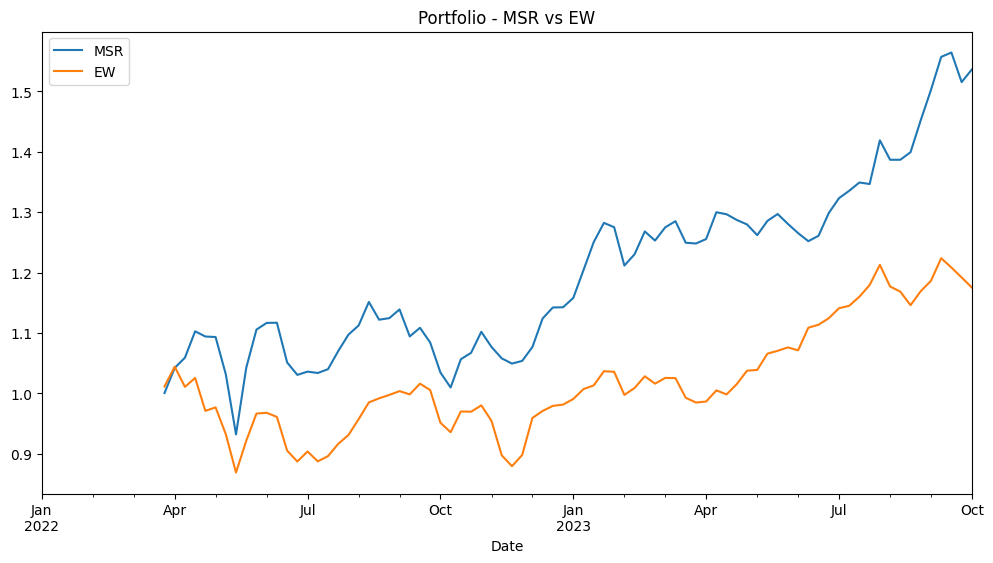

In [142]:
ewr = backtest_ws(data_test, estimation_window=12, weighting=weight_ew)
btr = pd.DataFrame({'MSR':btr_gmv, "EW": ewr})
(1+btr).cumprod().plot(figsize=(12, 6), title="Portfolio - MSR vs EW")
summary_stats(btr.dropna(), riskfree_rate=0.06, n_periods_per_year = 52)